# Milestone 2
Sivatagi Rohamcsigák
- Bodai Adrián Tibor
- Hermán Judit
- Kovács Kíra Diána
<br>
Task:<br>
Make a functional model. It does not have to be very good, but it should be at least functional and logical.



In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical, Sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, MultiHeadAttention, Input, Embedding, GlobalAveragePooling2D
from keras.optimizers import RMSprop,Adam
from keras.applications import VGG19, VGG16, ResNet50
from keras.models import Model

# Set up learning rate scheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import subprocess
import warnings
warnings.filterwarnings("ignore")

## Printing the GPU info
So that we make sure there is any available and all the dependency programs are set up properly

In [2]:
def get_gpu_info():
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'], capture_output=True, text=True)
        gpu_names = result.stdout.strip().split('\n')
        return gpu_names
    except Exception as e:
        print(f"Error while getting GPU info: {e}")
        return None

# Get GPU information
gpu_info = get_gpu_info()

if gpu_info:
    print("Available GPU(s):")
    for i, name in enumerate(gpu_info):
        print(f"GPU {i + 1}: {name}")
else:
    print("GPU information not available.")


Available GPU(s):
GPU 1: NVIDIA GeForce RTX 3060 Laptop GPU


## Data preperation
In this instance, we only trained on the 50 largest classes. We did not have the computing capacity to perform a good 80.000 class model, but the if the class number is rewritten, then the model should be repeatable just with a few clicks.

In [3]:
# Path
path = 'C:/Adrian/Egyetem-Msc/Deep Learning Python es LUA alapon/Project/landmark-recognition-2021/'

# Loading 
train_data = pd.read_csv(path+'train.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

# Some data about the dataset
print('Samples train length:', len(train_data))
print('Samples test length: ', len(samp_subm))
print('The number of CLASSes in the training', len(train_data['landmark_id'].unique()))

Samples train length: 1580470
Samples test length:  10345
The number of CLASSes in the training 81313


### Encdoing all the landmark_id-s to make the training possible

In [4]:
train_data_new = train_data.copy()
train_data_new['label_count'] = train_data_new.groupby('landmark_id')['landmark_id'].transform('count')
train_data_new = train_data_new.sort_values(by='label_count', ascending=False)

# Creating the encoder list
encoding = {}
i = 0
for landmark_id in train_data_new['landmark_id']:
    if landmark_id not in encoding:
        encoding[landmark_id] = i
        i += 1

train_data_new['encoded_landmark_id'] = [encoding[landmark_id] for landmark_id in train_data_new['landmark_id']]
train_data_new

,id,landmark_id,label_count,encoded_landmark_id
1081003,9a126324e671e76c,138982,6272,0
1077888,1a4519d92d84b71f,138982,6272,0
1077866,1939983af1b00f72,138982,6272,0
1077867,1941e9371698fc3a,138982,6272,0
1077868,195159c30049fa4e,138982,6272,0
...,...,...,...,...
1565685,f2ee16638bbfd38d,201132,2,81311
534382,c58da2095d2e99b2,68046,2,81312
534381,191e534566b0005c,68046,2,81312
1061404,6af494f0455fe2bf,136932,2,81307


In [5]:
data_modified = False
if data_modified:
    train_data_new.to_csv(path + 'train_corrected.csv')

train_data = pd.read_csv(path + 'train_corrected.csv')
train_data.index = train_data['Unnamed: 0'].values
train_data.drop('Unnamed: 0', axis='columns', inplace=True)
train_data

,id,landmark_id,label_count,encoded_landmark_id
1081003,9a126324e671e76c,138982,6272,0
1077888,1a4519d92d84b71f,138982,6272,0
1077866,1939983af1b00f72,138982,6272,0
1077867,1941e9371698fc3a,138982,6272,0
1077868,195159c30049fa4e,138982,6272,0
...,...,...,...,...
1565685,f2ee16638bbfd38d,201132,2,81311
534382,c58da2095d2e99b2,68046,2,81312
534381,191e534566b0005c,68046,2,81312
1061404,6af494f0455fe2bf,136932,2,81307


We had to cut the number of classes down to 50 because of hardwere limitations. We hope, that for this milestone it is enough, to teach the 50 largest classes to the network.

In [6]:
# listing the 50 largest class to perform the training. After that in the sample submission, we will cut with a treshold.
label_count = 100

#train_data_50 = train_data[train_data['encoded_landmark_id'] < label_count]
train_data_50 = train_data[train_data['label_count'] > label_count]
train_data_50

#class_counts = sorted({label: list(train_data['landmark_id']).count(label)  for label in train_data['landmark_id'].unique()})
#class_counts

,id,landmark_id,label_count,encoded_landmark_id
1081003,9a126324e671e76c,138982,6272,0
1077888,1a4519d92d84b71f,138982,6272,0
1077866,1939983af1b00f72,138982,6272,0
1077867,1941e9371698fc3a,138982,6272,0
1077868,195159c30049fa4e,138982,6272,0
...,...,...,...,...
835103,2a467d0a99b8e1c3,107718,101,1947
835100,269fb11ef718af91,107718,101,1947
835099,262e486ff95fe3dd,107718,101,1947
835098,257f4ab19850d2ce,107718,101,1947


In [7]:
# Creating the train and validation dataset
list_IDs_train, list_IDs_val = train_test_split(list(train_data_50.index), test_size=0.15, random_state=2023)
list_IDs_test = list(samp_subm.index)

print('Number train samples:', len(list_IDs_train))
print('Number val samples:', len(list_IDs_val))
print('Number test samples:', len(list_IDs_test))

Number train samples: 311151
Number val samples: 54909
Number test samples: 10345


In [1]:
!pip install pickle5

     ---------------------------------------- 0.0/132.1 kB ? eta -:--:--
     -------- ---------------------------- 30.7/132.1 kB 660.6 kB/s eta 0:00:01
     ----------------------------------- -- 122.9/132.1 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 132.1/132.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-39
      creating build\lib.win-amd64-cpython-39\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-39\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-39\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-39\pickle5
      creating build\lib.win-amd64-cpython-39\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-39\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-39\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-39\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-39\pickle5\test
      running build

## Data generator class
Wew had to write a data generator, because 100 GB of data could not fit into the memory<br>
<br>
If we have the time for it, we will try a transofmrer based approach on bigger resolution, but this is not (yet) the goal of this task<br>
<br>
We trained with batch size 8

In [8]:
# Setting batch size, we will use this value the entiry time
batch_size = 8

# Image meta data
img_size = 128
img_channel = 3
num_classes = len(train_data_50['landmark_id'].value_counts())

class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, img_size, img_channel, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.img_size = img_size
        self.img_channel = img_channel
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))
        self.value_to_enum = {value: enum for enum, value in enumerate(data['landmark_id'].unique())}
        
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel))
        y = np.zeros((self.batch_size, 1), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            
            image_id = self.data.loc[ID, 'id']
            file = image_id+'.jpg'
            subpath = '/'.join([char for char in image_id[0:3]]) 
            
            img = cv2.imread(self.path+subpath+'/'+file)
            
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img/255
            if self.path.find('train')>=0:
                y[i, ] = self.data.loc[ID, 'encoded_landmark_id']
            else:
                y[i, ] = 0
        return X, y

In [9]:
# Initalizing DataGenerators for all of preiods of the training and testing
train_generator = DataGenerator(path+'train/', list_IDs_train, train_data_50, img_size, img_channel, batch_size)
val_generator = DataGenerator(path+'train/', list_IDs_val, train_data_50, img_size, img_channel, batch_size)
# test_generator = DataGenerator(path+'test/', list_IDs_test, samp_subm, img_size, img_channel, batch_size)

## RESNET model on the largest 50 labels
In this instance, we used a RESNET50 based approach.<br>
We trained it in 10 epochs, in the first 5, the original weights of the RESNET model were untrainable, to preserve the pre training. After that for the last 5 epochs, we fine tuned the model with a smaller learning rate by enabling the training in all layers

In [10]:
RESNET_model = ResNet50(weights='imagenet', # initial weights
                        include_top=False, # Dropping the last layer
                        input_shape=(img_size, img_size, img_channel)) # setting input shape
# The initial status of the RESNET layers are untrainable
RESNET_model.trainable = False

model = Sequential()
model.add(RESNET_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=4e-5),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1971)              64587699  
                                                                 
Total params: 88,175,411
Trainable params: 64,587,699
Non-trainable params: 23,587,712
_________________________________________________________________


## Training the model

In [11]:
model_name = 'Resnet50_atLeast100TrainPic_1948classes'

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=1, min_lr=5e-8)
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'./models/{model_name}_best_model_justLast.h5', save_best_only=True)

# Training the model with early stopping
epochs_initializing = 15
epochs_trainable = 15

history_untrainable = model.fit_generator(generator=train_generator,
                                          validation_data=val_generator,
                                          epochs=epochs_initializing,
                                          workers=8,
                                          callbacks=[reduce_lr, early_stopping, model_checkpoint])
# Save the initialized model
model.save(f'./models/{model_name}_initialized.h5')

##### Second training cycle #####

# Loading the best model of the last training
model = load_model(f'./models/{model_name}_best_model_justLast.h5')
# Set all layers to be trainable
for layer in model.layers:
    layer.trainable = True
model_checkpoint = ModelCheckpoint(f'./models/{model_name}_best_model.h5', save_best_only=True)

# Training the model with early stopping
history_trainable = model.fit_generator(generator=train_generator,
                                        validation_data=val_generator,
                                        epochs=epochs_trainable,
                                        workers=8,
                                        callbacks=[reduce_lr, early_stopping, model_checkpoint])

# Save the final model
model.save(f'./models/{model_name}.h5')

Epoch 1/15
38894/38894 [==============================] - 1052s 27ms/step - loss: 7.1677 - sparse_categorical_accuracy: 0.0314 - val_loss: 6.8806 - val_sparse_categorical_accuracy: 0.0438 - lr: 4.0000e-05
Epoch 2/15
38894/38894 [==============================] - 1005s 26ms/step - loss: 6.7415 - sparse_categorical_accuracy: 0.0476 - val_loss: 6.7407 - val_sparse_categorical_accuracy: 0.0542 - lr: 4.0000e-05
Epoch 3/15
38894/38894 [==============================] - 998s 26ms/step - loss: 6.5578 - sparse_categorical_accuracy: 0.0584 - val_loss: 6.6950 - val_sparse_categorical_accuracy: 0.0568 - lr: 4.0000e-05
Epoch 4/15
38894/38894 [==============================] - 1001s 26ms/step - loss: 6.4408 - sparse_categorical_accuracy: 0.0657 - val_loss: 6.6632 - val_sparse_categorical_accuracy: 0.0669 - lr: 4.0000e-05
Epoch 5/15
38894/38894 [==============================] - 1001s 26ms/step - loss: 6.3591 - sparse_categorical_accuracy: 0.0714 - val_loss: 6.6509 - val_sparse_categorical_accuracy: 

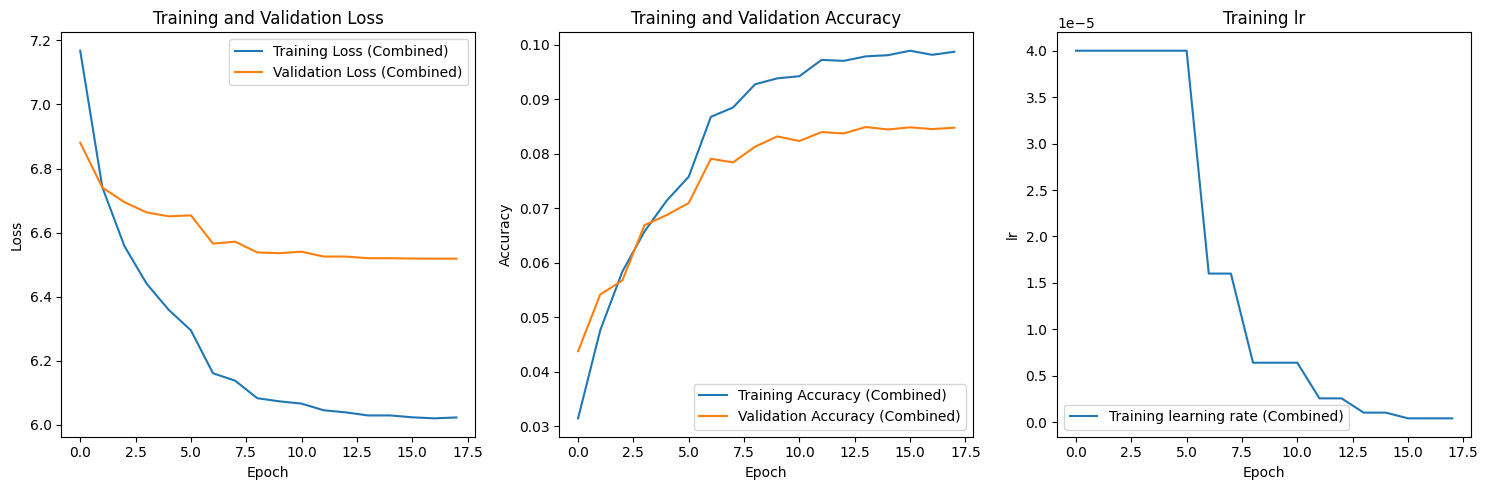

In [23]:
# Plotting the training history

# Combine the training history from both training stages
combined_history = {}
for key in history_untrainable.history.keys():
    combined_history[key] = history_untrainable.history[key] + history_trainable.history[key]

# Plot training loss and validation loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(combined_history['loss'], label='Training Loss (Combined)')
plt.plot(combined_history['val_loss'], label='Validation Loss (Combined)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(combined_history['sparse_categorical_accuracy'], label='Training Accuracy (Combined)')
plt.plot(combined_history['val_sparse_categorical_accuracy'], label='Validation Accuracy (Combined)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training learning rate separately
plt.subplot(1, 3, 3)
plt.plot(combined_history['lr'], label='Training learning rate (Combined)')
plt.xlabel('Epoch')
plt.ylabel('lr')
plt.title('Training lr')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
combined_history['lr']

[4e-05,
 4e-05,
 4e-05,
 4e-05,
 4e-05,
 4e-05,
 1.6e-05,
 1.6e-05,
 6.4e-06,
 6.4e-06,
 6.4e-06,
 2.56e-06,
 2.56e-06,
 1.024e-06,
 1.024e-06,
 4.0959998e-07,
 4.0959998e-07,
 4.0959998e-07]

## Making predictions with the model

In [13]:
# Set the model to evaluate
model_name = 'Resnet50_atLeast100TrainPic_1948classes'

model = load_model(f'./models/{model_name}_best_model.h5')

# Making the prediction 
val_generator = DataGenerator(path+'train/', list_IDs_val, train_data, img_size, img_channel, batch_size)
y_pred = model.predict(val_generator)

6864/6864 [==============================] - 534s 78ms/step


In [14]:

# Getting the original label for the predictions
original_class = [train_data_50.loc[ID, 'landmark_id'] for ID in list_IDs_val]

# Getting the column names by the landmark ids. The values will contain the probabilites of the belongings to each class
columns = []
for label in train_data_50['landmark_id']:
    if label not in columns:
        columns.append(label)


# Making the dataframe for the predictions
output = pd.DataFrame(columns=columns, data=y_pred)
print(len(y_pred), len(list_IDs_val))

output = output.head(len(list_IDs_val))
output['picture'] = list_IDs_val
output['original_class'] = original_class

output

54912 54909


,138982,126637,20409,83144,113209,177870,194914,149980,139894,1924,...,108517,17599,115091,30196,85018,47304,170717,128320,picture,original_class
0,0.000132,0.006019,1.415530e-03,0.003281,9.755789e-07,0.003648,1.466364e-04,0.000445,0.000271,0.000179,...,5.947373e-07,8.504005e-04,2.703339e-04,1.288987e-04,6.350642e-05,2.429904e-04,1.281671e-04,4.400961e-04,1363292,175360
1,0.000137,0.013857,5.228064e-03,0.003602,3.535477e-02,0.002185,3.669769e-03,0.003483,0.007518,0.009307,...,3.826639e-04,3.585056e-05,7.911792e-05,1.376858e-05,4.316525e-05,4.231421e-05,2.064112e-04,1.889725e-05,1093142,139980
2,0.000411,0.030758,6.766553e-04,0.005875,1.750169e-04,0.003690,7.284029e-04,0.002944,0.007415,0.007999,...,1.002625e-04,1.996789e-04,1.249502e-04,4.559983e-05,6.526672e-04,2.476981e-04,1.241747e-04,2.495265e-04,1518392,194914
3,0.000364,0.002732,4.022392e-08,0.000169,8.448668e-12,0.000388,1.786702e-02,0.000150,0.000419,0.001578,...,2.570577e-08,3.001215e-11,2.493146e-13,2.384550e-10,2.471887e-12,4.406538e-09,2.716071e-11,3.969909e-07,1222961,157472
4,0.000020,0.000672,2.084407e-03,0.000907,4.686060e-11,0.002519,7.997589e-07,0.000136,0.000041,0.000004,...,1.016889e-12,3.409093e-04,8.638234e-05,2.382528e-04,2.129989e-04,1.157348e-04,3.915588e-04,6.666356e-05,1347334,173350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54904,0.000042,0.008589,1.702912e-03,0.000056,9.171126e-09,0.000495,2.276344e-08,0.002464,0.000052,0.000037,...,3.500969e-09,3.251871e-06,2.725211e-05,1.811952e-03,1.810106e-04,1.480001e-03,6.712386e-06,1.363506e-06,232509,29794
54905,0.011893,0.008519,4.651942e-07,0.005978,9.479788e-12,0.006284,1.408180e-04,0.000456,0.001342,0.000285,...,2.073358e-11,2.319612e-07,1.802693e-10,2.049325e-06,2.203316e-05,3.187477e-06,1.646796e-09,4.845676e-07,882230,113838
54906,0.000088,0.007329,4.449114e-03,0.001527,4.534077e-04,0.002468,3.827892e-03,0.001538,0.001198,0.000584,...,1.205625e-04,1.261876e-04,2.358106e-04,9.788736e-05,1.013853e-04,2.010250e-04,9.145850e-05,1.490374e-04,417201,52547
54907,0.000002,0.001306,4.175652e-04,0.003260,1.116033e-06,0.003325,2.461998e-04,0.001058,0.000609,0.000277,...,1.233948e-05,2.709303e-04,4.727195e-04,5.080099e-04,4.077181e-04,8.002612e-04,1.105071e-04,1.518240e-04,631357,81133


In [15]:
# Printing the dataframe
output.to_csv(f'./preds/{model_name}_val_pred.csv', index=False)

# TODO
- Nyomtass ki egy overall enceded csv-t, category number alapján csökkenő
- Add hozzá a kimeneti oszlophoz a picture eredeti labelét, amellett hogy mik a predikciók
- Picture, original_class legyen az elején a pd-nek